<a href="https://colab.research.google.com/github/yohanesnuwara/66DaysOfData/blob/main/D07_imbalanced_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imbalanced Classification

3 strategies to resample imbalanced data:
* Undersampling: random technique
* Oversampling: SMOTE technique
* Combination of undersampling and oversampling

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import roc_auc_score, plot_confusion_matrix

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# Access dataset
url = 'https://raw.githubusercontent.com/yohanesnuwara/datasets/master/bank-full-encoded.csv'

df = pd.read_csv(url)

df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,40,4,1,2,0,3036,1,0,2,4,8,261,0,0,0,3,0
1,26,9,2,1,0,945,1,0,2,4,8,151,0,0,0,3,0
2,15,2,1,1,0,918,1,1,2,4,8,76,0,0,0,3,0
3,29,1,1,3,0,2420,1,0,2,4,8,92,0,0,0,3,0
4,15,11,2,3,0,917,0,0,2,4,8,198,0,0,0,3,0


Plot the pie chart of target labels.

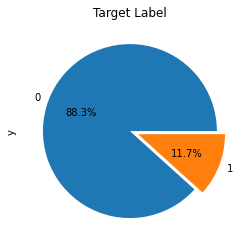

In [3]:
df.y.value_counts().plot(kind='pie', autopct='%1.1f%%', explode=(0,0.1))
plt.title('Target Label')
plt.show()

## Random Undersampling

Undersampling is used to resample majority data (data with more samples).

In [4]:
# Separating the independent variables from dependent variables
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

# Split train-test data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30)

# summarize class distribution
print("Before undersampling: ", Counter(y_train))

# define undersampling strategy
undersample = RandomUnderSampler(sampling_strategy='majority')

# fit and apply the transform
X_train_under, y_train_under = undersample.fit_resample(X_train, y_train)

# summarize class distribution
print("After undersampling: ", Counter(y_train_under))

Before undersampling:  Counter({0: 28007, 1: 3640})
After undersampling:  Counter({0: 3640, 1: 3640})


Fit AdaBoost classifier to data before undersampling.

In [5]:
model = AdaBoostClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# Evaluate model
scoring = ['accuracy', 'precision_macro', 'recall_macro']
scores_ori = cross_validate(model, X_train, y_train, 
                            scoring=scoring, cv=cv, n_jobs=-1)

# summarize performance
print('Mean Accuracy: %.4f' % np.mean(scores_ori['test_accuracy']))
print('Mean Precision: %.4f' % np.mean(scores_ori['test_precision_macro']))
print('Mean Recall: %.4f' % np.mean(scores_ori['test_recall_macro']))

Mean Accuracy: 0.8977
Mean Precision: 0.7581
Mean Recall: 0.6556


Fit AdaBoost classifier to data after undersampling. This takes much shorter time to train, because amount of data reduces after undersampling.

In [6]:
scores_under = cross_validate(model, X_train_under, y_train_under, 
                            scoring=scoring, cv=cv, n_jobs=-1)

# summarize performance
print('Mean Accuracy: %.4f' % np.mean(scores_under['test_accuracy']))
print('Mean Precision: %.4f' % np.mean(scores_under['test_precision_macro']))
print('Mean Recall: %.4f' % np.mean(scores_under['test_recall_macro']))

Mean Accuracy: 0.8239
Mean Precision: 0.8241
Mean Recall: 0.8239


A very huge jump of Recall from 0.65 to 0.83, meaning that the model is much getting better in predicting the minority class, even though Accuracy slightly decreases from 0.89 to 0.83.

## Oversampling with SMOTE

In [7]:
# Separating the independent variables from dependent variables
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

# Split train-test data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30)

# summarize class distribution
print("Before undersampling: ", Counter(y_train))

# define undersampling strategy
smote = SMOTE()

# fit and apply the transform
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

# summarize class distribution
print("After oversampling: ", Counter(y_train_over))

Before undersampling:  Counter({0: 27999, 1: 3648})
After oversampling:  Counter({1: 27999, 0: 27999})


Fit the same AdaBoost model to the oversampled data. This takes much longer time to train, because amount of data increases after oversampling.

In [8]:
scores_over = cross_validate(model, X_train_over, y_train_over, 
                            scoring=scoring, cv=cv, n_jobs=-1)

# summarize performance
print('Mean Accuracy: %.4f' % np.mean(scores_over['test_accuracy']))
print('Mean Precision: %.4f' % np.mean(scores_over['test_precision_macro']))
print('Mean Recall: %.4f' % np.mean(scores_over['test_recall_macro']))

Mean Accuracy: 0.8797
Mean Precision: 0.8800
Mean Recall: 0.8797


Shocking result! Recall and Accuracy get higher than when model is applied on undersampled data. 0.88 vs. 0.83. This means, oversampling is a better strategy for this data. 

## Combination

We can also combine undersampling and oversampling process in a pipeline.

In [9]:
model = AdaBoostClassifier()
under = RandomUnderSampler(sampling_strategy=0.5)
over = SMOTE(sampling_strategy=0.4)

# Put into pipeline
steps = [('o', over), ('u', under), ('model', model)]
pipe = Pipeline(steps=steps)

Fit the pipeline.

In [10]:
scores_pipe = cross_validate(pipe, X_train, y_train, 
                            scoring=scoring, cv=cv, n_jobs=-1)

# summarize performance
print('Mean Accuracy: %.4f' % np.mean(scores_pipe['test_accuracy']))
print('Mean Precision: %.4f' % np.mean(scores_pipe['test_precision_macro']))
print('Mean Recall: %.4f' % np.mean(scores_pipe['test_recall_macro']))

Mean Accuracy: 0.8741
Mean Precision: 0.7046
Mean Recall: 0.7516


Using pipeline, Recall 0.75 is no better than the previous strategies of undersampling and oversampling. 

## Determine best sampling ratios

Previously, we use combination of undersampling with 0.5 sampling ratio and oversampling with 0.4 sampling ratio, and we get not enough good result. We can search the best ratios and use ROC AUC as metric.  

In [11]:
# values to evaluate
over_values = [0.3, 0.4, 0.5]
under_values = [0.7, 0.6, 0.5]

for o in over_values:
  for u in under_values:
    # define pipeline
    model = AdaBoostClassifier()
    over = SMOTE(sampling_strategy=o)
    under = RandomUnderSampler(sampling_strategy=u)
    steps = [('over', over), ('under', under), ('model', model)]
    pipeline = Pipeline(steps=steps)

    # evaluate pipeline
    scores = cross_val_score(pipeline, X_train, y_train, 
                             scoring='roc_auc', cv=5, n_jobs=-1)
    score = np.mean(scores)
    print('SMOTE oversampling rate:%.1f, Random undersampling rate:%.1f , Mean ROC AUC: %.3f' % (o, u, score))

SMOTE oversampling rate:0.3, Random undersampling rate:0.7 , Mean ROC AUC: 0.886
SMOTE oversampling rate:0.3, Random undersampling rate:0.6 , Mean ROC AUC: 0.888
SMOTE oversampling rate:0.3, Random undersampling rate:0.5 , Mean ROC AUC: 0.889
SMOTE oversampling rate:0.4, Random undersampling rate:0.7 , Mean ROC AUC: 0.883
SMOTE oversampling rate:0.4, Random undersampling rate:0.6 , Mean ROC AUC: 0.883
SMOTE oversampling rate:0.4, Random undersampling rate:0.5 , Mean ROC AUC: 0.882
SMOTE oversampling rate:0.5, Random undersampling rate:0.7 , Mean ROC AUC: 0.878
SMOTE oversampling rate:0.5, Random undersampling rate:0.6 , Mean ROC AUC: 0.879
SMOTE oversampling rate:0.5, Random undersampling rate:0.5 , Mean ROC AUC: 0.879


Reviewing the above result, the best combination is undersampling 0.3 and oversampling 0.6, which results an ROC AUC score of 0.893. 

References:
* https://towardsdatascience.com/how-to-deal-with-imbalanced-data-in-python-f9b71aba53eb
* https://towardsdatascience.com/imbalanced-classification-in-python-smote-enn-method-db5db06b8d50